# 06_03: Name Popularity

In [1]:
import math
import collections
import dataclasses
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

We are ready to start analyzing the data. Let's load it up.

In [10]:
allyears = pd.read_feather('allyears.feather')

In [11]:
allyears

,name,sex,number,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
31677,Zyell,M,5,2023
31678,Zyen,M,5,2023
31679,Zymirr,M,5,2023
31680,Zyquan,M,5,2023


We want to examine the changing popularity of a name, so we can index the data to make that easier. We will use a multi-index, indexing on sex first, then name, then year. We will also sort the index.

In [12]:
allyears_indexed = allyears.set_index(['sex','name','year']).sort_index()

In [23]:
allyears_indexed

number
sex name   year        
F   Aabha  2011       7
           2012       5
           2014       9
           2015       7
           2016       7
...                 ...
M   Zyvion 2009       5
    Zyvon  2015       7
    Zyyon  2014       6
    Zzyzx  2010       5
           2018       5

[2117219 rows x 1 columns]

Getting the dataset for any given name is then a simple exercise of indexing with `.loc`.

In [13]:
allyears_indexed.loc[('F','Mary')]

,number
year,
1880,7065
1881,6919
1882,8148
1883,8012
1884,9217
...,...
2019,2237
2020,2225
2021,2097


This series is ready to plot. Notice how matplotlib automatically uses the index to set the x axis.

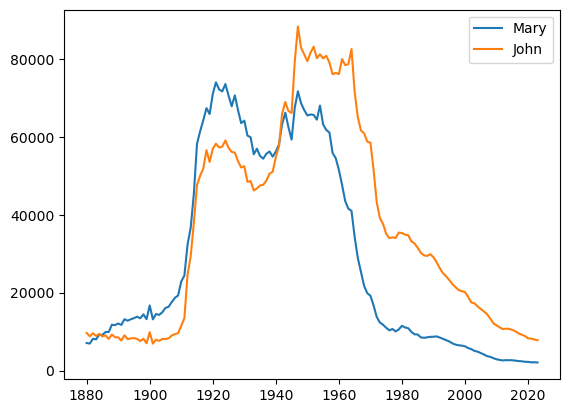

In [48]:
pp.plot(allyears_indexed.loc[('F','Mary'), 'number'], label='Mary')
pp.plot(allyears_indexed.loc[('M','John'), 'number'], label='John')
pp.legend();

It probably makes sense also to consider the frequency of a name as a fraction of the number of babies born in a year. To get that, we use groupby to group the un-indexed frame by sex and year, and sum the number column.

In [25]:
births = allyears.groupby(['sex','year']).number.sum()

This gives us the total number of births, indexed by sex and year, which is by itself interesting to plot. We see the baby boomers coming on stage in the 50s and 60s!

In [26]:
births

sex  year
F    1880      90994
     1881      91953
     1882     107847
     1883     112320
     1884     129019
              ...   
M    2019    1792223
     2020    1723649
     2021    1746499
     2022    1741954
     2023    1701224
Name: number, Length: 288, dtype: int64[pyarrow]

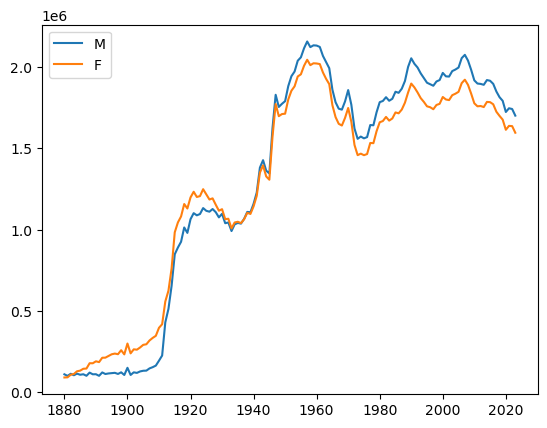

In [41]:
pp.plot(births.loc['M'], label='M')
pp.plot(births.loc['F'], label='F')
pp.legend();

We can now create a new column in `allyears_indexed` equal to the relative frequency of a name in a year.

In [46]:
allyears_indexed['fraction'] = allyears_indexed.number / births

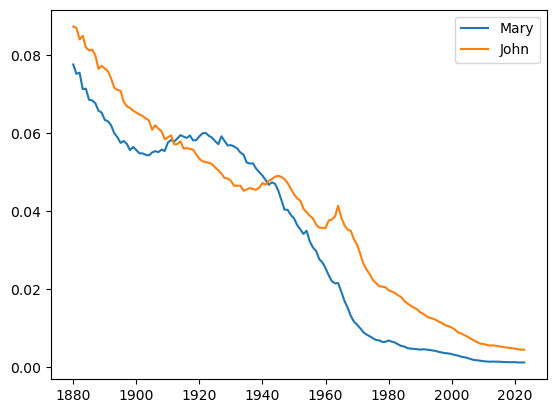

In [49]:
pp.plot(allyears_indexed.loc[('F','Mary'), 'fraction'], label='Mary')
pp.plot(allyears_indexed.loc[('M','John'), 'fraction'], label='John')
pp.legend();

So as a percentage of all babies, Mary and John have steadily lost popularity. In 1880 more than 8 percent of all baby boys was a John!

Let's make a generic function `plotname` to make this kind of plot, and another function to plot a few names together. We'll be interested in absolute numbers _and_ percentage of births. 

In [60]:
def plotname(sex, name, relative=False):
    data = allyears_indexed.loc[(sex, name), 'fraction' if relative else 'number']
    
    pp.plot(data.index, data.values, label=name)
    pp.axis(xmin=1880, xmax=2023)

In [65]:
def comparenames(sex, names, relative=False):
    for name in names:
        plotname(sex, name, relative)

    pp.legend()

For instance, Michael John David Martin

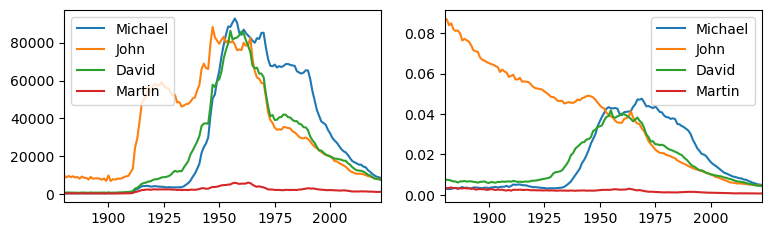

In [73]:
pp.figure(figsize=(9,2.5))
pp.subplot(1,2,1); comparenames('M', ['Michael','John','David','Martin'])
pp.subplot(1,2,2); comparenames('M', ['Michael','John','David','Martin'], relative=True)

Or for girls, Emily, Anna, Claire, Elizabeth

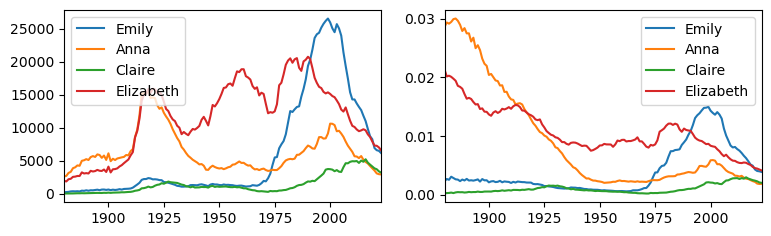

In [74]:
pp.figure(figsize=(9,2.5))
pp.subplot(1,2,1); comparenames('F', ['Emily','Anna','Claire','Elizabeth'])
pp.subplot(1,2,2); comparenames('F', ['Emily','Anna','Claire','Elizabeth'], relative=True)

Another interesting investigation is to compare variants of the same name. For instance, the two spellings of Claire, the older version Clara, and the italian and irish spelling of chiara.

In [225]:
claires = ['Claire', 'Clare', 'Clara', 'Chiara', 'Ciara']

Notice how matplotlib does its best to put the legend out of the way...

Claire is dominant, but Clara is having a resurgence. Notice the purple spike just after 2004, when the singer Ciara (see-ah-ra) released her first album.

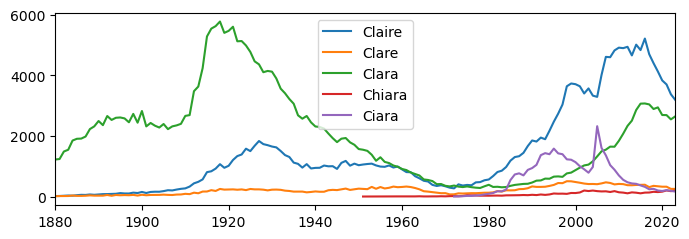

In [86]:
pp.figure(figsize=(8,2.5))
comparenames('F', claires)

We can make a slightly different cumulative, or _stacked_ plot that adds up the counts on top of each other.

For that, we need a _table_ where the rows are the Claire variants, and the columns are years. Indexing gives us the data we need.

In [227]:
allyears_indexed.loc[('F', claires), 'number']

sex  name    year
F    Claire  1880     21
             1881     23
             1882     30
             1883     38
             1884     33
                    ... 
     Ciara   2019    204
             2020    188
             2021    215
             2022    192
             2023    169
Name: number, Length: 547, dtype: int64[pyarrow]

Now, pandas DataFrames have methods `stack()` and `unstack()` which can switch labels from columns to the index, and vice versa. Thus, using unstack will give us a table.

In [235]:
allyears_indexed.loc[('F', claires), 'number'].unstack(level=2)

year        1880  1881  1882  1883  1884  1885  1886  1887  1888  1889  ...  \
sex name                                                                ...   
F   Claire    21    23    30    38    33    49    61    58    73    62  ...   
    Clare     15    20    21    22    38    27    26    31    43    34  ...   
    Clara   1226  1242  1490  1548  1852  1910  1916  1984  2230  2319  ...   
    Chiara  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
    Ciara   <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   

year        2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  
sex name                                                                
F   Claire  5015  4836  5216  4701  4404  4130  3835  3702  3379  3195  
    Clare    387   389   394   315   357   344   329   329   257   257  
    Clara   2860  3069  3075  3044  2892  2946  2694  2691  2550  2648  
    Chiara   131   111   134   137   161   152   166   206   182   200  
    Ciara    424   372   324   244   259   204   188   215   192   169  

[5 rows x 144 columns]

Using `unstack` on the name would have given us a transposed table.

In [240]:
allyears_indexed.loc[('F', claires), 'number'].unstack(level=1)

name      Claire  Clare  Clara  Chiara  Ciara
sex year                                     
F   1880      21     15   1226    <NA>   <NA>
    1881      23     20   1242    <NA>   <NA>
    1882      30     21   1490    <NA>   <NA>
    1883      38     22   1548    <NA>   <NA>
    1884      33     38   1852    <NA>   <NA>
...          ...    ...    ...     ...    ...
    2019    4130    344   2946     152    204
    2020    3835    329   2694     166    188
    2021    3702    329   2691     206    215
    2022    3379    257   2550     182    192
    2023    3195    257   2648     200    169

[144 rows x 5 columns]

Then `stack` brings us back, except that we have swapped around the index levels.

In [241]:
allyears_indexed.loc[('F', claires), 'number'].unstack(level=1).stack()

sex  year  name  
F    1880  Claire      21
           Clare       15
           Clara     1226
     1881  Claire      23
           Clare       20
                     ... 
     2023  Claire    3195
           Clare      257
           Clara     2648
           Chiara     200
           Ciara      169
Length: 547, dtype: int64[pyarrow]

But let's go back to our table.

In [242]:
allyears_indexed.loc[('F', claires), 'number'].unstack(level=2)

year        1880  1881  1882  1883  1884  1885  1886  1887  1888  1889  ...  \
sex name                                                                ...   
F   Claire    21    23    30    38    33    49    61    58    73    62  ...   
    Clare     15    20    21    22    38    27    26    31    43    34  ...   
    Clara   1226  1242  1490  1548  1852  1910  1916  1984  2230  2319  ...   
    Chiara  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
    Ciara   <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   

year        2014  2015  2016  2017  2018  2019  2020  2021  2022  2023  
sex name                                                                
F   Claire  5015  4836  5216  4701  4404  4130  3835  3702  3379  3195  
    Clare    387   389   394   315   357   344   329   329   257   257  
    Clara   2860  3069  3075  3044  2892  2946  2694  2691  2550  2648  
    Chiara   131   111   134   137   161   152   166   206   182   200  
    Ciara    424   372   324   244   259   204   188   215   192   169  

[5 rows x 144 columns]

This is just what we need. We may as well lose the index label for "sex", which doesn't do anything. We do that with `droplevel`. And while we're massaging this table, we may as well replace the missing values with zeros, which we do with `fillna`. By the way, this style of manipulating DataFrames by combining a sequence of operations is called chaining, and some developers like it a lot. The backslashes at the end of each lines are needed so that Python sees the whole expression as a single line.

In [306]:
unstacked = allyears_indexed.loc[('F', claires), 'number'] \
                            .unstack(level=2) \
                            .droplevel(level=0) \
                            .fillna(0)

In [281]:
unstacked

year,1880,1881,1882,1883,1884,1885,1886,1887,1888,1889,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
name,,,,,,,,,,,,,,,,,,,,,
Claire,21,23,30,38,33,49,61,58,73,62,...,5015,4836,5216,4701,4404,4130,3835,3702,3379,3195
Clare,15,20,21,22,38,27,26,31,43,34,...,387,389,394,315,357,344,329,329,257,257
Clara,1226,1242,1490,1548,1852,1910,1916,1984,2230,2319,...,2860,3069,3075,3044,2892,2946,2694,2691,2550,2648
Chiara,0,0,0,0,0,0,0,0,0,0,...,131,111,134,137,161,152,166,206,182,200
Ciara,0,0,0,0,0,0,0,0,0,0,...,424,372,324,244,259,204,188,215,192,169


We should be good. Except that `matplotlib`, which still lives in the `numpy` universe, cannot quite handle the pyarrow integers. The error is about applying a specific `numpy` function to a type that is not understood.

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

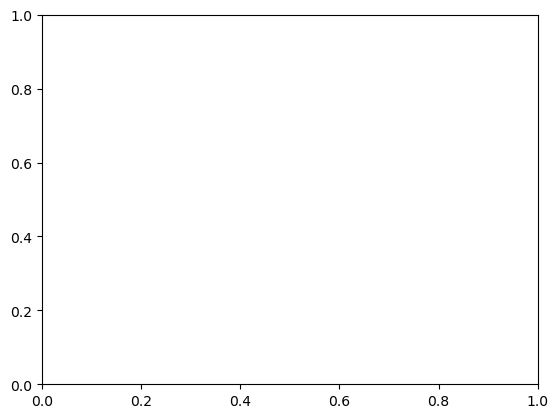

In [284]:
pp.stackplot(unstacked.columns, unstacked)

No big deal: we just convert them to numpy integers, using `astype`. The column names gives us labels for the x axis, while the index makes a suitable legend.

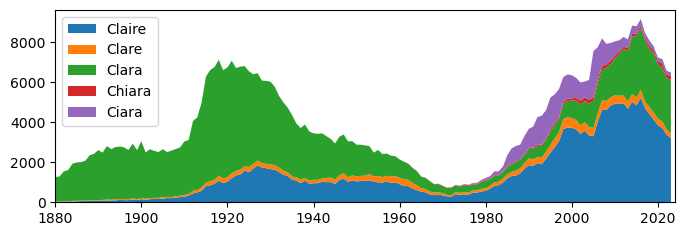

In [289]:
pp.figure(figsize=(8,2.5))
pp.stackplot(unstacked.columns, unstacked.astype(np.int32))
pp.legend(unstacked.index, loc='upper left');
pp.axis(xmin=1880, xmax=2024);

Quite nice and informative. Except perhaps for the garish default colors chosen by matplotlib. Surely we can do better!

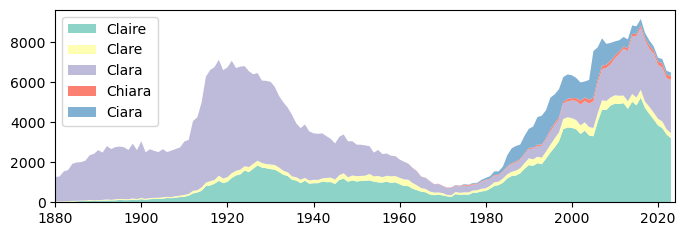

In [305]:
pp.figure(figsize=(8,2.5))
pp.stackplot(unstacked.columns, unstacked.astype(np.int32),
             colors=pp.get_cmap('Set3')(range(5))) # get the first five colors from the "Set3" matplotlib colormap  
pp.legend(unstacked.index, loc='upper left');
pp.axis(xmin=1880, xmax=2024);